# LSTM Time series (Keras/Tensorflow)

In [1]:
import os

import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from LSTM import *

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

figures saved to ../Figures/Modeling/LSTM


## Data exploration

In [5]:
files = os.listdir('../Datasets/fastStorage/2013-8')
files.sort()  # Short the files (compatible with mac)
files[742]

'541.csv'

In [7]:
# Load data
# VM = load_VM('917.csv')
VM = load_VM('541.csv')
# Make it univariate
df = VM[['CPU usage [MHZ]']]
# df = VM

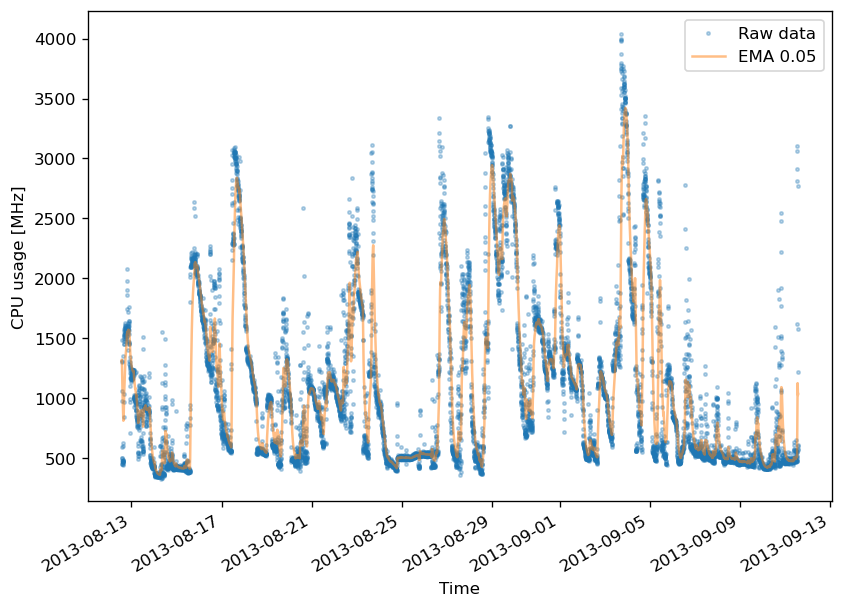

In [8]:
%matplotlib inline
plot_timeSeries(df['CPU usage [MHZ]'], ylabel='CPU usage [MHz]')

Metal device set to: Apple M1


2022-03-07 11:55:36.625295: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-07 11:55:36.625460: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


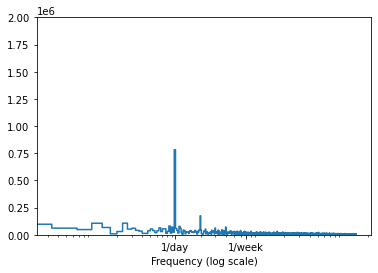

In [5]:
%matplotlib inline
fft = tf.signal.rfft(df['CPU usage [MHZ]'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(VM)
timestamps_per_day = 60*24/5
days_per_dataset = n_samples_h/ (timestamps_per_day)

f_per_day = f_per_dataset/days_per_dataset
plt.step(f_per_day, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 2000000)
# plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 7], labels=['1/day', '1/week'])
_ = plt.xlabel('Frequency (log scale)')

## Split the data

In [4]:
# (70%, 20%, 10%) split for the training, validation, and test sets
train_df, val_df, test_df = split_data(df)

## Normalizing the data

In [5]:
scaler = StandardScaler()
train_df, val_df, test_df = data_transformation(scaler, train_df, val_df, test_df)

## Adding daily info

In [8]:
df = add_daily_info(df)
# (70%, 20%, 10%) split for the training, validation, and test sets
train_df, val_df, test_df = split_data(df)

/Users/javier.galindos/Library/CloudStorage/OneDrive-FundaciónIMDEASoftware/Documents/Code/intern-project-javier/Modeling/LSTM.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
/Users/javier.galindos/Library/CloudStorage/OneDrive-FundaciónIMDEASoftware/Documents/Code/intern-project-javier/Modeling/LSTM.py:214: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
/Users/javier.galindos/Library/Cloud

Text(0.5, 1.0, 'Time of day signal')

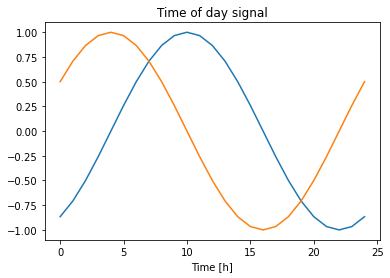

In [9]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

## LSTM

In [6]:
lstm_model = LstmModel(input_width=50,
                      label_width=9,
                      df=df,
                      name='StandardScaling',
                      train_df=train_df,
                      val_df=val_df,
                      test_df=test_df,
                      epoch=100,
                      units=20,
                      layers=1,
                      dropout=0,
                      )

Metal device set to: Apple M1


2022-03-08 14:31:01.606940: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-08 14:31:01.607088: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
# Magic func to use TensorBoard directly in IPython
%load_ext tensorboard

In [12]:
log_dir = f'logs/fit/{lstm_model.name}'
%tensorboard --logdir=logdir

Launching TensorBoard...

In [7]:
IPython.display.clear_output()
history = lstm_model.compile_and_fit(patience=50)

Input shape (batch, time, features): (664, 50, 1)
Labels shape (batch, time, features): (664, 9, 1)
Output shape:(664, 9, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                1760      
                                                                 
 dense (Dense)               (None, 9)                 189       
                                                                 
 reshape (Reshape)           (None, 9, 1)              0         
                                                                 
Total params: 1,949
Trainable params: 1,949
Non-trainable params: 0
_________________________________________________________________
Beginning training
Epoch 1/100


2022-03-08 14:31:05.755537: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-08 14:31:06.126637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-08 14:31:06.249220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1/6 [====>.........................] - ETA: 3s - loss: 1.0339 - mean_absolute_error: 0.8221

2022-03-08 14:31:06.397924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 0.9850 - mean_absolute_error: 0.8112

2022-03-08 14:31:06.910007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-08 14:31:06.957991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 111ms/step - loss: 0.9850 - mean_absolute_error: 0.8112 - val_loss: 0.7934 - val_mean_absolute_error: 0.7166
Epoch 2/100
6/6 [==============================] - 0s 31ms/step - loss: 0.9464 - mean_absolute_error: 0.7935 - val_loss: 0.7561 - val_mean_absolute_error: 0.6967
Epoch 3/100
6/6 [==============================] - 0s 29ms/step - loss: 0.8973 - mean_absolute_error: 0.7700 - val_loss: 0.7092 - val_mean_absolute_error: 0.6704
Epoch 4/100
6/6 [==============================] - 0s 28ms/step - loss: 0.8380 - mean_absolute_error: 0.7410 - val_loss: 0.6582 - val_mean_absolute_error: 0.6405
Epoch 5/100
6/6 [==============================] - 0s 28ms/step - loss: 0.7791 - mean_absolute_error: 0.7109 - val_loss: 0.6123 - val_mean_absolute_error: 0.6128
Epoch 6/100
6/6 [==============================] - 0s 28ms/step - loss: 0.7232 - mean_absolute_error: 0.6810 - val_loss: 0.5715 - val_mean_absolute_error: 0.5870
Epoch 7/100
6/6 [======================

In [8]:
IPython.display.clear_output()
pred = lstm_model.prediction(scaler)

Inference:


2022-03-08 14:31:51.715231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-08 14:31:51.757493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Inference time: 0.24 sec
6/6 [==============================] - 0s 20ms/step - loss: 0.2602 - mean_absolute_error: 0.3882


In [9]:
metrics = lstm_model.evaluation(pred,scaler)

In [27]:
val_mape = lstm_model.model.evaluate(lstm_model.window.val[0], lstm_model.window.val[1])

53/53 [==============================] - 1s 10ms/step - loss: 0.0021 - mean_absolute_error: 0.0347


In [12]:
# Figure
%matplotlib tk
test_trf = scaler.inverse_transform(test_df)
test_df_trf = pd.DataFrame(data=test_trf, columns=test_df.columns, index=test_df.index)
fig = plt.figure(dpi=150)
plt.grid()
test_df_trf['CPU usage [MHZ]'].plot(label='actual', color='k')
pred['CPU usage [MHZ]'].plot(label='forecast')
plt.ylabel('CPU usage [MHz]')
plt.title(f'Val MAPE:')
plt.grid()
plt.legend()
plt.show()

In [25]:
%matplotlib tk
defaultKwargs = {'marker': 'o',
                 'linestyle': '',
                 'alpha': 0.3,
                 'markersize': 2}
kwargs_forecast = {'marker': 'o',
                 'linestyle': '',
                 'alpha': 0.5,
                 'markersize': 2,
                  'color': 'tab:orange'}
fig = plt.figure(dpi=200)
plt.grid()
lstm_model.df['CPU usage [MHZ]'].plot(label='actual', color='k', **defaultKwargs)
pred['CPU usage [MHZ]'].plot(label='forecast', **kwargs_forecast)
plt.ylabel('CPU usage [MHz]')
plt.title(f'Val MAE:')
plt.grid()
plt.legend()
plt.show()

In [17]:
test_trf = scaler.inverse_transform(lstm_model.test_df)
test_df_trf = pd.DataFrame(data=test_trf, columns=lstm_model.test_df.columns, index=lstm_model.test_df.index)


In [26]:
fig = plt.figure(dpi=200)
plt.grid()
test_df_trf['CPU usage [MHZ]'].plot(label='actual', color='k', **defaultKwargs)
pred['CPU usage [MHZ]'].plot(label='forecast', **kwargs_forecast)
plt.ylabel('CPU usage [MHz]')
plt.title(f'Val MAE:')
plt.grid()
plt.legend()
plt.show()

# Baseline

In [6]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [7]:
baseline = Baseline(label_index=df['CPU usage [MHZ]'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

Metal device set to: Apple M1


2022-03-04 14:11:31.300024: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-04 14:11:31.300597: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    batch_size=1,
    label_columns=['CPU usage [MHZ]'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['CPU usage [MHZ]']

In [17]:
base_pred = baseline.predict(single_step_window.train[0])

TypeError: in user code:

    File "/Users/javier.galindos/miniforge3/envs/native_m1/lib/python3.9/site-packages/keras/engine/training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "/Users/javier.galindos/miniforge3/envs/native_m1/lib/python3.9/site-packages/keras/engine/training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/javier.galindos/miniforge3/envs/native_m1/lib/python3.9/site-packages/keras/engine/training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/javier.galindos/miniforge3/envs/native_m1/lib/python3.9/site-packages/keras/engine/training.py", line 1572, in predict_step
        return self(x, training=False)
    File "/Users/javier.galindos/miniforge3/envs/native_m1/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    TypeError: Exception encountered when calling layer "baseline" (type Baseline).
    
    in user code:
    
        File "/var/folders/mb/34bz2n2j38ldt4zjxtdpnfg80000gp/T/ipykernel_12480/1421947583.py", line 9, in call  *
            result = inputs[:, :, self.label_index]
    
        TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got Timestamp [ms]
        2013-08-12 13:40:00    712.399891
        2013-08-12 13:45:00    741.866553
        2013-08-12 13:50:00    727.999889
        2013-08-12 13:55:00    643.066568
        2013-08-12 14:00:00    636.133236
                                  ...    
        2013-09-11 13:15:00    582.399877
        2013-09-11 13:20:00    545.999885
        2013-09-11 13:25:00    556.399882
        2013-09-11 13:30:00    698.533186
        2013-09-11 13:35:00    669.066525
        Name: CPU usage [MHZ], Length: 8617, dtype: float64
    
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, None, 1), dtype=float32)
